In [2]:
# code to replicate arXiv:1412.2043v2
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import astropy.units as u
import astropy.constants as c
# all units should be natural units and in GeV unless otherwise noted

In [126]:
# naive implementation of rhs
def rhs_naive(t, y, m_a, f_a, Gamma_phi):
    # friedmann
    a, a_dot, n_L, rho_phi, rho_R = y
    rho_total = rho_phi + rho_R
    H = np.sqrt(rho_total) / (np.sqrt(3) * M_pl)
    T = calc_temperature(rho_R)
    # axion eom
    axion_pot_deriv = m_a**2 * a
    a_dot2 = - 3 * H * a - axion_pot_deriv
    # boltzmann eq. for lepton asymmetry
    mu_eff = a_dot / f_a
    n_L_eq = 4 / np.pi**2 * mu_eff * T**2
    n_l_eq = 2 / np.pi**2 * T**3
    Gamma_L = 4 * n_l_eq * sigma_eff
    n_L_dot = - 3 * H * n_L - Gamma_L * (n_L - n_L_eq)
    # reheating energy equations
    rho_phi_dot = - 3 * H * rho_phi - Gamma_phi * rho_phi
    rho_R_dot   = - 4 * H * rho_R   + Gamma_phi * rho_phi
    # final result
    y_dot = [a_dot, a_dot2, n_L_dot, rho_phi_dot, rho_R_dot]
    return y_dot

In [16]:
# constants
M_pl = 2.435e18 # [GeV] from wikipedia (https://en.wikipedia.org/wiki/Planck_mass)
g_star = 427/4 # during reheating from paper
sigma_eff = 1e-31 # [GeV^-2] from paper heavy neutrino exchange 
N_f = 3 # [1] fermion generations
# TODO: renormalization group running?
g_2 = 0.652 # [1] from wikipedia (https://en.wikipedia.org/wiki/Mathematical_formulation_of_the_Standard_Model#Free_parameters)
alpha = g_2**2 / (4 * np.pi) # eq. from paper
theta0 = 1 # use value from paper for now (maybe vary it later?)
H_inf_max = 2e10 # from fig. 1
c_shaleron = 28/79 # from paper
g_star_0 = 43/11 # from paper
eta_B_observed = 6e-10 # from paper
L_to_B_final_factor = c_shaleron * g_star_0 / g_star # formula from paper (*)
t_end_inf = (1e-32 * u.second / c.hbar).to("1/GeV").value # [1/eV] number from wikipedia, is that what is used? https://en.wikipedia.org/wiki/Inflationary_epoch 
print("t_end_inf =", t_end_inf)

t_end_inf = 1.519267447878626e-08


In [87]:
# helper functions
def eta_L_a_to_eta_B_0(eta_L_a): 
    return L_to_B_final_factor * eta_L_a # formula from paper (*)

def calc_Gamma_a(m_a, f_a):
    return alpha**2 / (64 * np.pi**3) * m_a**3 / f_a**2 # from paper

def calc_a0(f_a):
    return theta0 * f_a # from paper, standard definition

def calc_temperature(rho_R):
    # in the paper its
    # (np.pi**2 / 3 * g_star * rho_R)**(1/4)
    # but I think it should be 
    return (np.pi**2 / 30 * g_star * rho_R)**(1/4)

def calc_hubble_parameter(rho_total):
    return np.sqrt(rho_total) / (np.sqrt(3) * M_pl)

def calc_rho_R(rho_phi, rho_tot):
    return rho_tot - rho_phi # neglegt axion 

In [131]:
# https://pdg.lbl.gov/2020/reviews/rpp2020-rev-inflation.pdf eq. (23.19)
# energy density for coherant oscillations of the inflaton field.
# At the beginning this should be valid, since rho_R ~ 0
def calc_rho_phi_initial_analytical(t0):
    return M_pl**2 / (6*np.pi*t0**2)

def calc_rho_phi_analytical(t0, t, R_osc, R, Gamma_phi):
    return calc_rho_phi_initial_analytical(t0) * (R / R_osc)**-3 * np.exp(- Gamma_phi * (t - t0))

def calc_rho_R_analytical(t0, t, Gamma_phi):
    return M_pl**2 * Gamma_phi / (10*np.pi * t) * (1 - (t / t0)**(-5/3))

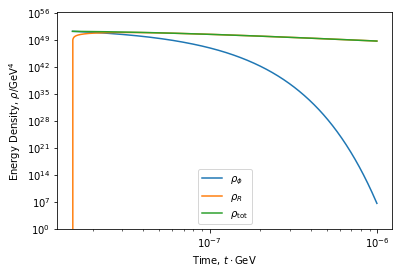

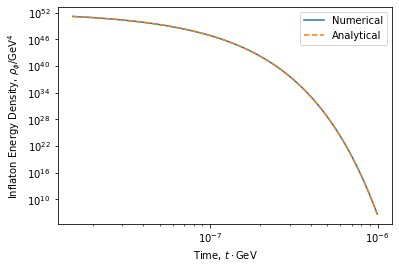

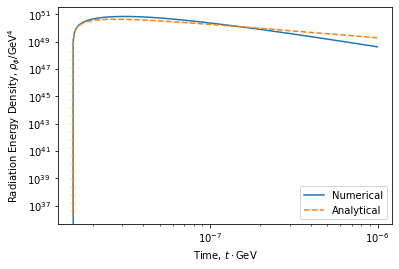

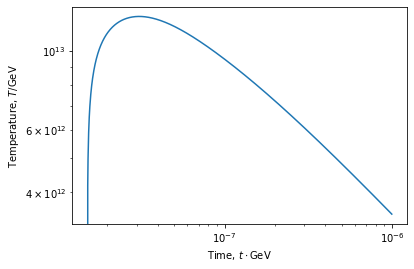

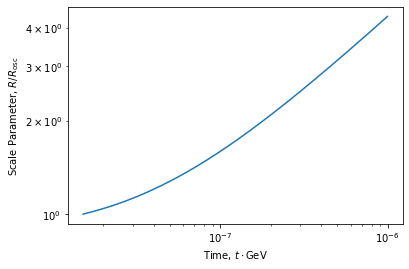

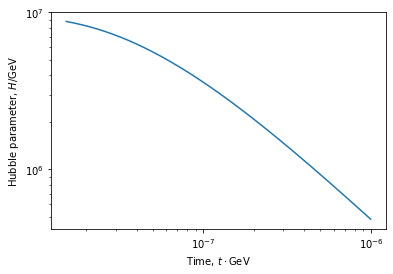

In [135]:
def rhs(log_t, log_y, Gamma_phi):
    # coordinate transformation
    t, y = np.exp(log_t), np.exp(log_y)
    rho_phi, rho_tot, R = y
    rho_R = calc_rho_R(rho_phi, rho_tot)
    # friedmann
    H = calc_hubble_parameter(rho_tot)
    d_log_R_d_log_t = t * H
    # reheating energy equations rewritten in rho_phi and roh_tot instead of rho_phi and phi_R and in loglog space
    d_log_rho_phi_d_log_t = - t * (3 * H + Gamma_phi)
    d_log_rho_tot_d_log_t = - H * t * (4 - rho_phi / rho_tot)
    # final result
    return d_log_rho_phi_d_log_t, d_log_rho_tot_d_log_t, d_log_R_d_log_t

# test parameters
m_a = 1e8 # [GeV]
f_a = 3e14 # [GeV] from fig. 1
Gamma_phi = 1e8 # [GeV]

# run solver
rho_phi_0 = calc_rho_phi_initial_analytical(t_end_inf)
R_osc = 1.0
initial_condition = np.array([rho_phi_0, rho_phi_0, R_osc])
Gamma_a = calc_Gamma_a(m_a, f_a)
t_axion_decay = 1 / Gamma_a
# interval = (t_end_inf, t_axion_decay) # required interval for leptogenesis computation (also works)
interval = (t_end_inf, 1e-6) # test
# float problem last point outside of t interval
sol = solve_ivp(rhs, np.log(interval), np.log(initial_condition), 
                args=(Gamma_phi,), t_eval=np.log(np.geomspace(*interval, 1000))[:-1], 
                method="Radau",)
t = np.exp(sol.t)
rho_phi, rho_tot, R = np.exp(sol.y)
rho_R = calc_rho_R(rho_phi, rho_tot)
T = calc_temperature(rho_R)
H = calc_hubble_parameter(rho_tot)

# plot results
time_label = r"Time, $t \cdot \mathrm{GeV}$"

# reheating energy densities
plt.figure()
plt.loglog(t, rho_phi, label=r"$\rho_\phi$")
plt.loglog(t, rho_R, label=r"$\rho_R$")
plt.loglog(t, rho_tot, label=r"$\rho_\mathrm{tot}$")
plt.legend()
plt.xlabel(time_label)
plt.ylabel(r"Energy Density, $\rho / \mathrm{GeV}^4$")
plt.ylim((1, initial_condition[0]**1.1))
plt.show()

# inflaton field energy density
plt.figure()
plt.xlabel(time_label)
plt.ylabel(r"Inflaton Energy Density, $\rho_\phi / \mathrm{GeV}^4$")
plt.loglog(t, rho_phi, label="Numerical")
plt.loglog(t, calc_rho_phi_analytical(t_end_inf, t, R_osc, R, Gamma_phi), ls="--", label="Analytical")
plt.legend()
plt.show()

# radiation energy density from reheating
plt.figure()
plt.xlabel(time_label)
plt.ylabel(r"Radiation Energy Density, $\rho_\phi / \mathrm{GeV}^4$")
plt.loglog(t, rho_R, label="Numerical")
plt.loglog(t, calc_rho_R_analytical(t_end_inf, t, Gamma_phi), ls="--", label="Analytical")
plt.legend()
plt.show()

# temperature
plt.figure()
plt.loglog(t, T)
plt.xlabel(time_label)
plt.ylabel(r"Temperature, $T / \mathrm{GeV}$")
plt.show()

# scale factor
plt.figure()
plt.loglog(t, R / R_osc)
plt.xlabel(time_label)
plt.ylabel(r"Scale Parameter, $R / R_\mathrm{osc}$")
plt.show()

# Hubble parameter
plt.figure()
plt.loglog(t, H)
plt.xlabel(time_label)
plt.ylabel(r"Hubble parameter, $H / \mathrm{GeV}$")
plt.show()

In [98]:
np.log(t_axion_decay)

25.77352905238079

## Analytical Solution

In [10]:
def calc_Delta_a(m_a, f_a, Gamma_phi):
    a0 = calc_a0(f_a)
    Delta_a_prime = 2*np.pi**2 / alpha * f_a * a0**2 / (m_a * M_pl**2) * min((1, (Gamma_phi / m_a)**0.5))
    Delta_a = max((1, Delta_a_prime))
    return Delta_a

def calc_eta_L_a_analytic(m_a, f_a, Gamma_phi):
    Gamma_a = calc_Gamma_a(m_a, f_a)
    a0 = calc_a0(f_a)
    eta_L_max = sigma_eff * a0 / (g_star**0.5 * f_a) * m_a * M_pl * min((1, (Gamma_phi / m_a)**0.5))
    Delta_phi_prime = (m_a / Gamma_phi)**(5 / 4)
    Delta_phi = max((1, Delta_phi_prime))
    Delta_a = calc_Delta_a(m_a, f_a, Gamma_phi)
    T_RH = 2e13*(Gamma_phi / 1e9)**0.5
    T_L = g_star**0.5 / (np.pi * M_pl * sigma_eff)
    kappa = np.where(m_a > Gamma_phi, T_RH / T_L, 0)
    C = np.where(m_a > Gamma_phi, 2.2, 1.5) # factor determined in paper
    eta_L_a = C * Delta_a**-1 * Delta_phi**-1 * eta_L_max * np.exp(-kappa)
    return eta_L_a

In [11]:
f_a_list = [1e12, 1e12, 1e15, 1e15]
m_a_list = [3e7, 3e6, 1e10, 1e9]
Gamma_phi_list = [3e6, 3e7, 1e9, 1e10]
def print_table():
    print("f_a, m_a, Gamma_phi, eta_L^a, Delta_a")
    for f_a, m_a, Gamma_phi in zip(f_a_list, m_a_list, Gamma_phi_list):
        print(f"{f_a:e}, {m_a:e}, {Gamma_phi:e}, {eta_L_a_to_eta_B_0(calc_eta_L_a_analytic(m_a, f_a, Gamma_phi)):e}, {calc_Delta_a(m_a, f_a, Gamma_phi):e}")
print_table() # 

f_a, m_a, Gamma_phi, eta_L^a, Delta_a
1.000000e+12, 3.000000e+07, 3.000000e+06, 3.315723e-10, 1.000000e+00
1.000000e+12, 3.000000e+06, 3.000000e+07, 1.378704e-09, 1.000000e+00
1.000000e+15, 1.000000e+10, 1.000000e+09, 8.760594e-09, 3.112049e+00
1.000000e+15, 1.000000e+09, 1.000000e+10, 4.669852e-09, 9.841164e+01


Text(0.5, 1.0, 'Analytic Expression for the Baryon Asymmetry')

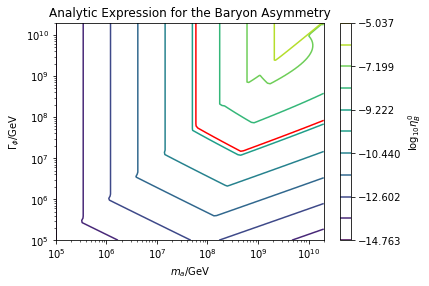

In [52]:
# make a plot of the final baryon asymmetry as a function of the axion mass and the inflaton
# decay rate and highlight the contourline with the observed asymmetry
steps = 100
f_a = 3e14
Gamma_phis = np.geomspace(1e5, H_inf_max, steps) # constraint
m_as = np.geomspace(1e5, H_inf_max, steps + 1) # constraint
eta_B_0 = np.array([[eta_L_a_to_eta_B_0(calc_eta_L_a_analytic(m_a, f_a, Gamma_phi)) 
            for m_a in m_as] for Gamma_phi in Gamma_phis])
log_eta = np.log10(eta_B_0)
levels = np.sort(np.concatenate([np.linspace(np.min(log_eta), np.max(log_eta), 10), [np.log10(eta_B_observed)]]))
CS = plt.contour(m_as, Gamma_phis, log_eta, levels=levels)
cbar = plt.colorbar()
cbar.set_label(r"$\log_{10} \eta_B^0$")
line = CS.collections[np.where(CS.levels == np.log10(eta_B_observed))[0][0]]
line.set_color("red")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"$m_a / \mathrm{GeV}$")
plt.ylabel(r"$\Gamma_\phi / \mathrm{GeV}$")
plt.title("Analytic Expression for the Baryon Asymmetry")

In [55]:
# isocurvature_constraint:
# H_inf_max < 6e11 * (f_a / 1e15) # True if okay
# H_inf_max / (6e11 / 1e15) < f_a 
f_a_min = H_inf_max / (6e11 / 1e15)
"%e" % f_a_min

'3.333333e+13'